# Mask R-CNN - Predict


In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.draw


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")


In [2]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from glob import glob


import cable

%matplotlib inline 

# Directories to be referred
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "datasets/cable/predict/")
ANNOTATION_DIR = os.path.join(ROOT_DIR, "datasets/cable/")
WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_cable_0100.h5")

Using TensorFlow backend.


## Configurations

In [3]:
config = cable.CableConfig()

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.825
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INS

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load the Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [8]:
# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights  /home/michael/Bachelor/important/Cable-detection/Mask_RCNN-2.1/logs/mask_rcnn_cable_0100.h5


## Prediction and merge masks

In [9]:
file_names = glob(os.path.join(IMAGE_DIR, "*.jpg"))
masks_prediction = np.zeros((900, 1200, len(file_names)))
for i in range(len(file_names)):
    print(file_names[i])
    print(i)
    image = skimage.io.imread(file_names[i])
    predictions = model.detect([image],  verbose=1)
    p = predictions[0]
    masks = p['masks']
    merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
    for j in range(masks.shape[2]):
        merged_mask[masks[:,:,j]==True] = True
        masks_prediction[:,:,i] = merged_mask
print(masks_prediction.shape)

/home/michael/Bachelor/important/Cable-detection/Mask_RCNN-2.1/datasets/cable/predict/802.jpg
0
Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/michael/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/michael/Bachelor/important/Cable-detection/Mask_RCNN-2.1/datasets/cable/predict/807.jpg
1
Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
/home/michael/Bachelor/important/Cable-detection/Mask_RCNN-2.1/datasets/cable/predict/809.jpg
2
Processing 1 images
image                    shape: (900, 1200, 3)        min:    2.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
/hom

## Load Annotations

In [10]:
dataset = cable.CableDataset()
dataset.load_cable(ANNOTATION_DIR, "predict")

In [12]:
accuracy = 0
precision = 0
for image_id in range(len(dataset.image_info)):
    name = dataset.image_info[image_id]['id']
    file_name = os.path.join(IMAGE_DIR, name)
    image_id_pred = file_names.index(file_name)
    merged_mask = masks_prediction[:, :, image_id_pred]
    
    annotated_mask = dataset.load_mask(image_id)[0]
    merged_annotated_mask = np.zeros((900, 1200))
    for i in range(annotated_mask.shape[2]):
        merged_annotated_mask[annotated_mask[:,:,i]==True] = True
    accuracy  += np.sum(merged_mask==merged_annotated_mask) / (1200 * 1600)
    all_correct = np.sum(merged_annotated_mask[merged_mask == 1])
    precision += all_correct / (np.sum(merged_mask))
print('accuracy:{}'.format(accuracy / len(file_names)))
print('precision:{}'.format(precision / len(file_names)))

accuracy:0.5510917187500001
precision:nan


/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Processing 1 images
image                    shape: (900, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



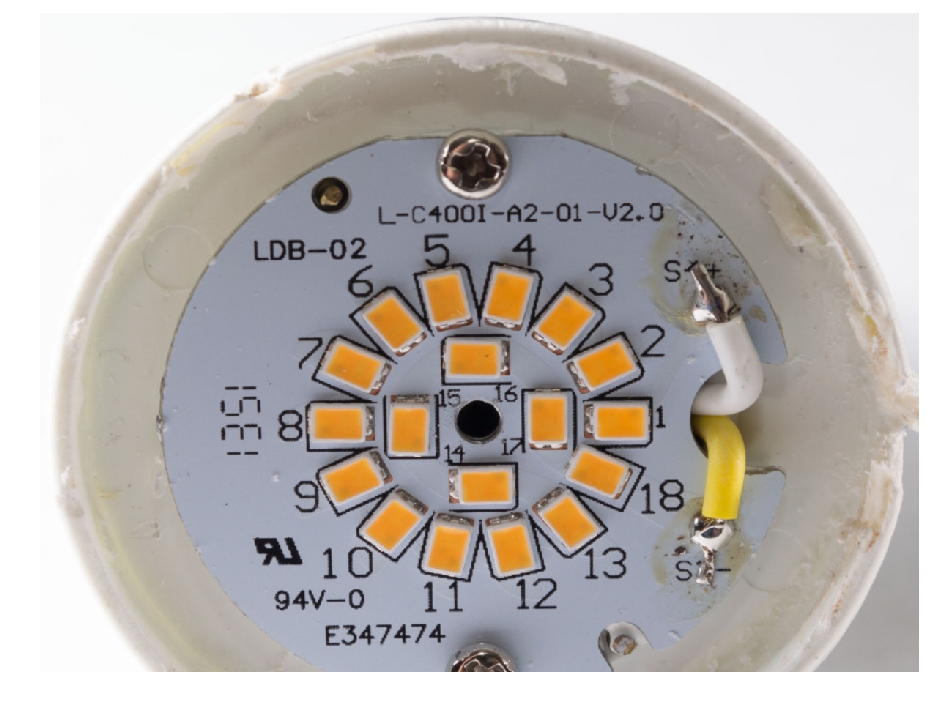

In [22]:
file_names = glob(os.path.join(IMAGE_DIR, "*.jpg"))
class_names = ['BG', 'cable']
test_image = skimage.io.imread(file_names[9])#random.randint(0,len(file_names)-1)])
predictions = model.detect([test_image], verbose=1) # We are replicating the same image to fill up the batch_size
p = predictions[0]
image = visualize.display_instances(test_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])
